In [1]:
# 导入需要的包
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimSun']
# 读取数据
data_path = r'D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\train (1).csv'
df = pd.read_csv(data_path)

print(df.describe())  # 查看数据描述
print(df.head())    # 查看数据内容
# 检测缺失值
missing_values = df.isnull().sum()
print("缺失值检测：")
print(missing_values)

        Active_Power     Wind_Speed  Weather_Temperature_Celsius  \
count  192375.000000  192375.000000                192375.000000   
mean        6.069226       2.264729                    20.507981   
std         7.649238       2.522313                     9.612143   
min        -0.058133    -919.076392                    -5.807769   
25%         0.000000       1.071627                    13.644258   
50%         0.000000       1.947894                    20.751801   
75%        14.320868       3.274227                    27.651313   
max        23.426197      43.782015                    45.285713   

       Weather_Relative_Humidity  Global_Horizontal_Radiation  \
count              192375.000000                192375.000000   
mean                   37.861451                   258.577693   
std                    24.092746                   354.715687   
min                     3.125814                  -985.690002   
25%                    18.487015                     2.892378 

In [2]:
# 检测异常值（使用箱线图法）
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

columns_to_check = [
    'Active_Power', 'Wind_Speed', 'Weather_Temperature_Celsius',
    'Weather_Relative_Humidity', 'Global_Horizontal_Radiation',
    'Diffuse_Horizontal_Radiation', 'Wind_Direction',
    'Weather_Daily_Rainfall', 'Radiation_Global_Tilted',
    'Radiation_Diffuse_Tilted'
]

print("异常值检测：")
for column in columns_to_check:
    outliers = detect_outliers(df, column)
    print(f"{column} 异常值数量: {len(outliers)}")

# 删除相关系数小于0.1的列
correlation_matrix = df.corr()
low_correlation_columns = correlation_matrix[correlation_matrix['Active_Power'] < 0.1].index
df.drop(columns=low_correlation_columns, inplace=True)
print(df.columns)

异常值检测：
Active_Power 异常值数量: 0
Wind_Speed 异常值数量: 457
Weather_Temperature_Celsius 异常值数量: 0
Weather_Relative_Humidity 异常值数量: 0
Global_Horizontal_Radiation 异常值数量: 69
Diffuse_Horizontal_Radiation 异常值数量: 15043
Wind_Direction 异常值数量: 1169
Weather_Daily_Rainfall 异常值数量: 10475
Radiation_Global_Tilted 异常值数量: 4262
Radiation_Diffuse_Tilted 异常值数量: 12869
Index(['timestamp', 'Active_Power', 'Wind_Speed',
       'Weather_Temperature_Celsius', 'Global_Horizontal_Radiation',
       'Diffuse_Horizontal_Radiation', 'Radiation_Global_Tilted',
       'Radiation_Diffuse_Tilted'],
      dtype='object')


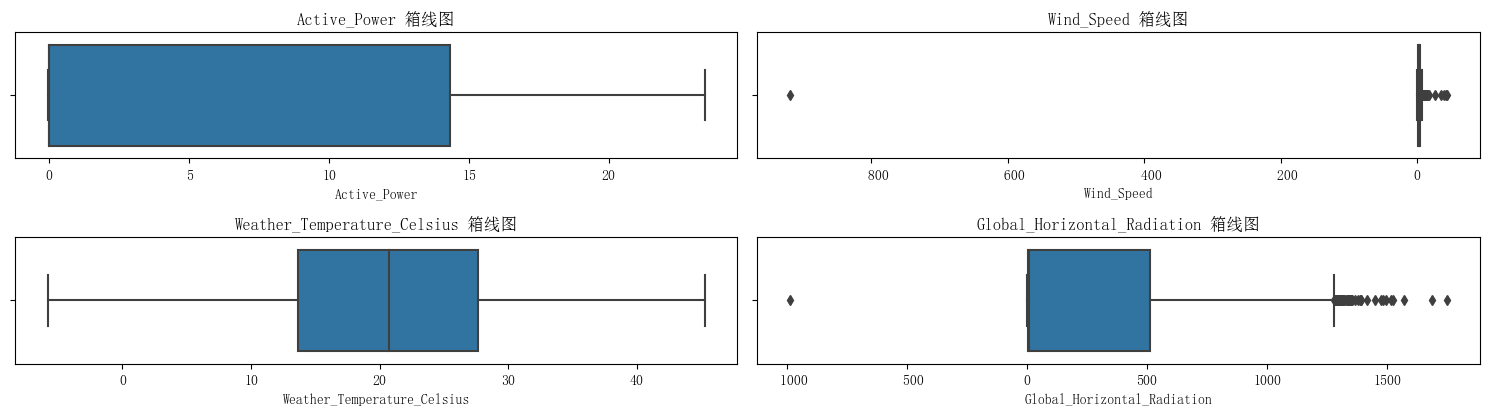

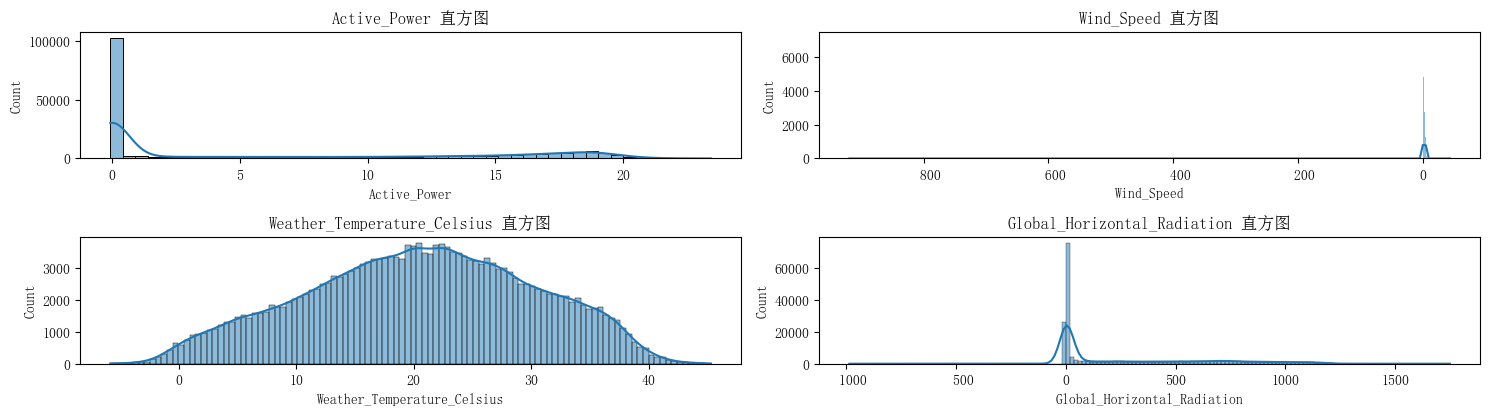

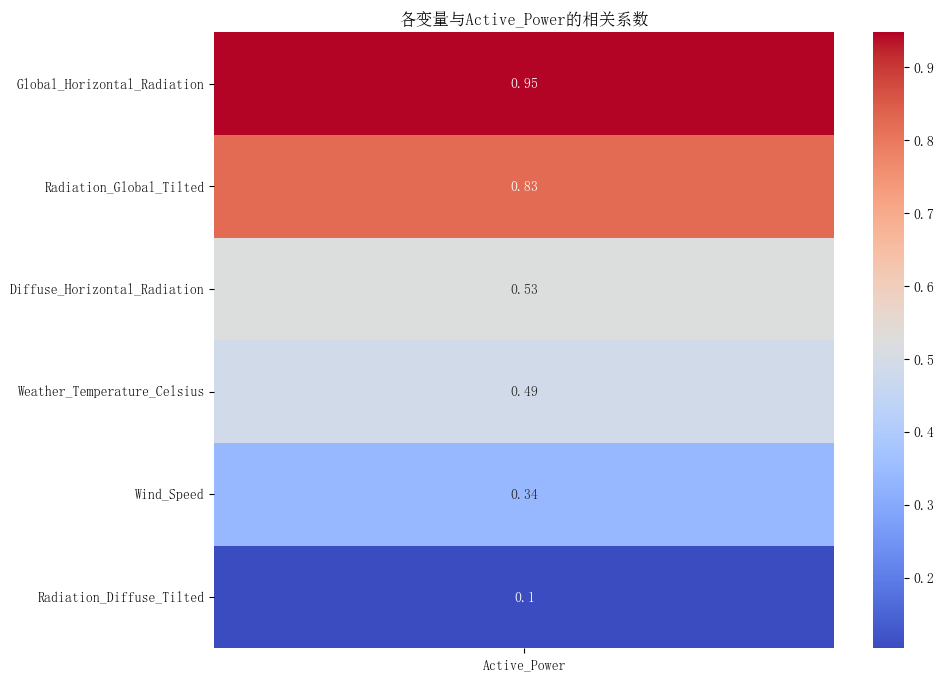

In [3]:
# 简单可视化
def visualize_columns(df, columns):
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(columns, 1):
        plt.subplot(5, 2, i)
        sns.boxplot(x=df[column])
        plt.title(f'{column} 箱线图')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 10))
    for i, column in enumerate(columns, 1):
        plt.subplot(5, 2, i)
        sns.histplot(df[column], kde=True)
        plt.title(f'{column} 直方图')
    plt.tight_layout()
    plt.show()

    # 相关系数可视化
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix[['Active_Power']].drop('Active_Power').sort_values(by='Active_Power', ascending=False), annot=True, cmap='coolwarm')
    plt.title('各变量与Active_Power的相关系数')
    plt.show()

# 选择要可视化的列
columns_to_visualize = [
    'Active_Power', 'Wind_Speed',
    'Weather_Temperature_Celsius','Global_Horizontal_Radiation'
]

visualize_columns(df, columns_to_visualize)

从Wind_Speed的图可以看出，箱子被压得很扁，甚至只剩下一条线,这些情况的出现，有两个常见的原因。第一，样本数据中，存在特别大或者特别小的异常值，这种离群的表现，导致箱子整体被压缩，反而凸显出来这些异常；第二，样本数据特别少，因此箱体受单个数据的影响被放大了。
因此进行一下异常值的简单处理。

没有处理前，辐照度出现了负数。

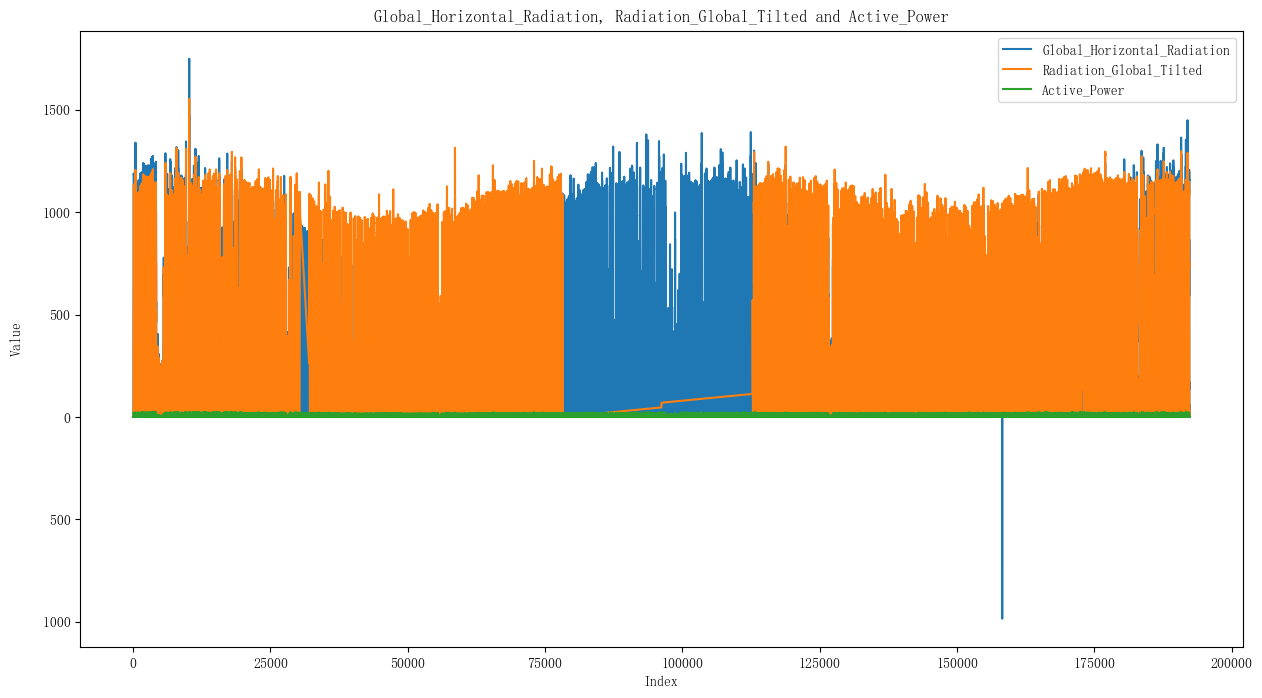

In [4]:
# 定义绘制三条曲线的函数
def plot_three_curves(df, start=0, end=1000):
    plt.figure(figsize=(15, 8))
    plt.plot(df['Global_Horizontal_Radiation'][start:end], label='Global_Horizontal_Radiation')
    plt.plot(df['Radiation_Global_Tilted'][start:end], label='Radiation_Global_Tilted')
    plt.plot(df['Active_Power'][start:end], label='Active_Power')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Global_Horizontal_Radiation, Radiation_Global_Tilted and Active_Power')
    plt.legend()
    plt.show()

# 调用绘制函数，指定绘制范围
plot_three_curves(df, start=0, end=-1)

In [5]:
# 检测并填补异常值（使用平均值和标准差法）
def detect_and_fill_outliers(df, column):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    df[column] = df[column].mask((df[column] < lower_bound) | (df[column] > upper_bound))
    df[column].interpolate(method='cubic', inplace=True)

columns_to_check = ['Active_Power', 'Wind_Speed',
       'Weather_Temperature_Celsius', 'Global_Horizontal_Radiation',
       'Diffuse_Horizontal_Radiation', 'Radiation_Global_Tilted',
       'Radiation_Diffuse_Tilted']

print("异常值填补：")
for column in columns_to_check:
    detect_and_fill_outliers(df, column)
    print(f"{column} 异常值已填补")

异常值填补：
Active_Power 异常值已填补
Wind_Speed 异常值已填补
Weather_Temperature_Celsius 异常值已填补
Global_Horizontal_Radiation 异常值已填补
Diffuse_Horizontal_Radiation 异常值已填补
Radiation_Global_Tilted 异常值已填补
Radiation_Diffuse_Tilted 异常值已填补


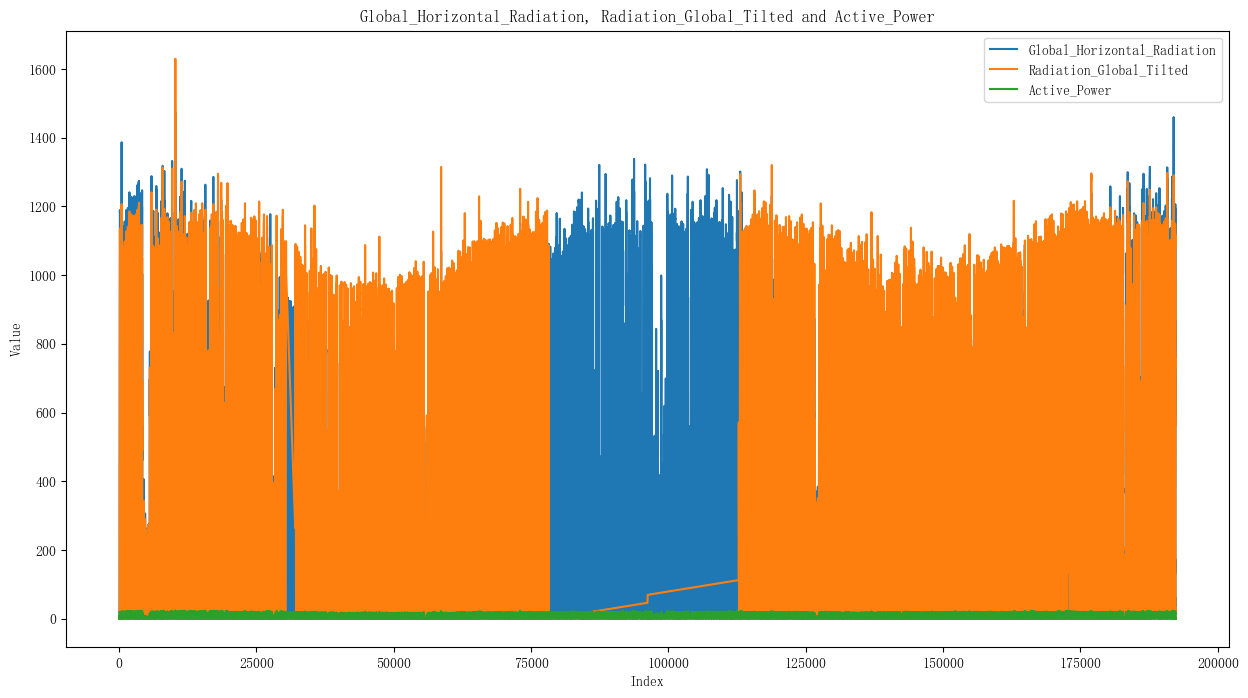

In [6]:
# 保存初步处理完的数据
plot_three_curves(df, start=0, end=-1)
# 如果需要保存处理后的DataFrame，可以使用以下代码
# df.to_csv("D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\step1_data.csv",index=False)

step1_data.csv数据是初步处理的结果，经过观察，发现两个问题：

1.在第70000到110000个点之间，Radiation_Diffuse_Tilted这一变量有很多的0值，这里先尝试将这段时间的序列整体删除掉，从2014.9.29到2015.2.28都不要了

2.功率Active_Power这一变量不应该有负数，考虑到功率为负数时候发电量为0了，一般处于晚上或者凌晨，因此需要将需要变为0

后续处理的时候考虑到这两个问题，然后筛选一下时间，判定为从6点到19点，其他时间段的数据就不要了。

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
# 发现删除了可以提高预测效果，但是在测试集上不能直接删除，为了保证模型的学习能力这里不删除，并且时间也不去筛选
# # 1. 删除2014.9.29到2015.2.28这段时间的序列
# start_date = '2014-09-29'
# end_date = '2015-02-28'
# df = df[~((df['timestamp'] >= start_date) & (df['timestamp'] <= end_date))]

# 2. 每天只保留6点到19点的数据
# df = df[(df['timestamp'].dt.hour >= 6) & (df['timestamp'].dt.hour <= 19)]

# 3. 如果检测到功率Active_Power<0，那就将其赋值为0
df.loc[df['Active_Power'] < 0, 'Active_Power'] = 0
# # 如果需要保存处理后的DataFrame，可以使用以下代码
df.to_csv("D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\step2_data.csv", index=False)


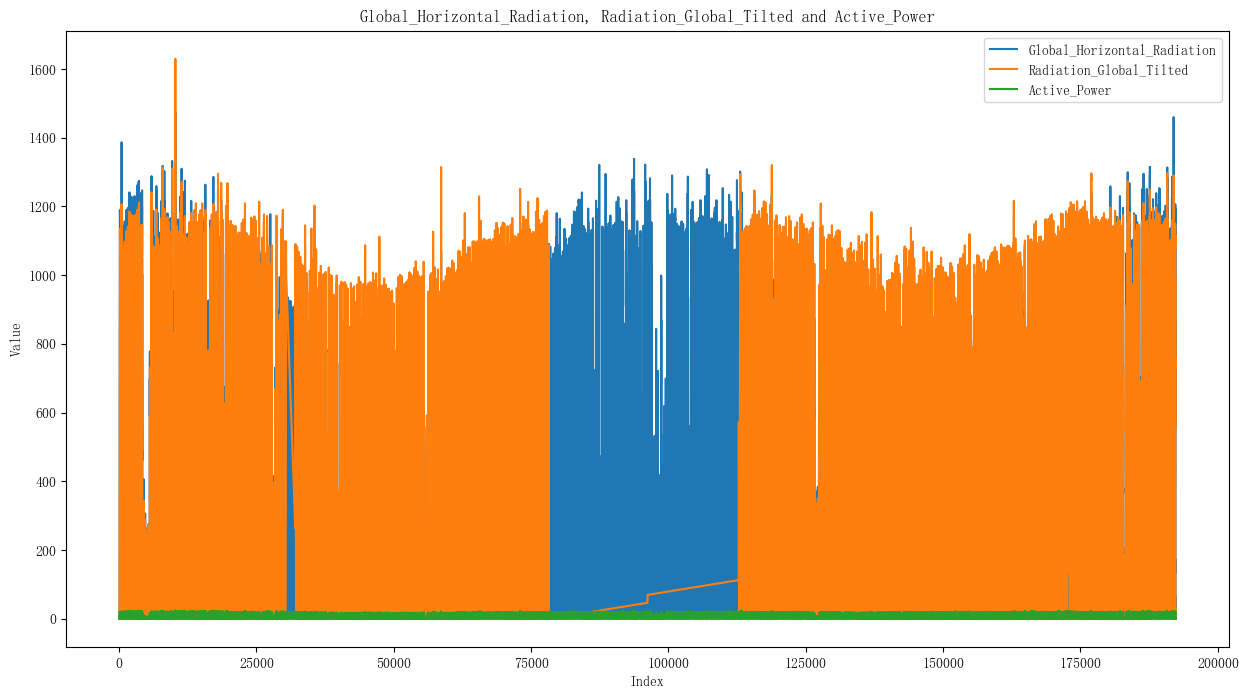

In [8]:
#此时看一下数据什么样
Data_step2 = pd.read_csv("D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\step2_data.csv")
plot_three_curves(Data_step2, start=0, end=-1)

step2_data.csv数据是再次处理的结果，后续就用它来进行后续的工作。

这里先进行特征工程的制作，论文中有很多方法，包括二阶导数、多变量做差之类的，各选取一部分看看。“没有好的特征组合，模型再强也是没用。”

由于经过相关系数的分析，剩下的大多是和辐照度有关的变量，为了增强模型对剩下特征Wind_Speed和Temperature的学习能力，可以在这里做点文章。

之前恰好看到这篇：{On the value of expert knowledge in estimation and forecasting of solar photovoltaic power generation. https://doi.org/10.1016/j.solener.2023.01.019}

他是参考的04年的{Photovoltaic array performance model}中的Sandia 模型,$T_c$就是新增加的板温：

$T_m=E\cdot\left\{e^{a+b\cdot WS}\right\}+T_a$

$T_c=T_m+\frac{E}{E_o}\cdot\Delta T$

这里的E对应Radiation_Global_Tilted；WS对应Wind_Speed；$T_a$对应Weather_Temperature_Celsius；$E_o$为参考太阳辐照度，通常为1000 W/m2.

a和b是根据经验确定的系数，确定模块温度在低风速和高太阳辐照度下的上限和下限，这里参考该文章的18-20页。

使用文章的系数，a=-3.23,b=-0.13,$\Delta T$=13

In [9]:
import numpy as np
# 定义常量
a = -3.23
b = -0.13
E_o = 1000
delta_T = 13
# 计算 T_c
Data_step2['T_c'] = (Data_step2['Radiation_Global_Tilted'] * np.exp(a + b * Data_step2['Wind_Speed'])
                     + Data_step2['Weather_Temperature_Celsius']) + (Data_step2['Radiation_Global_Tilted'] / E_o) * delta_T

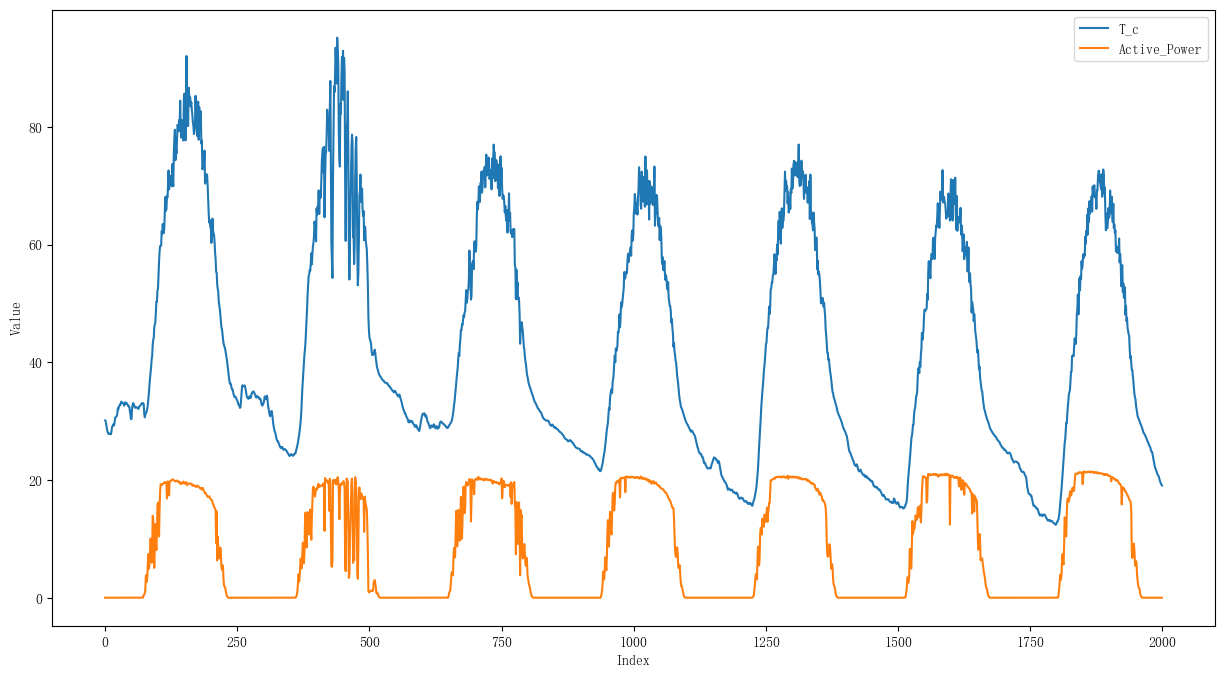

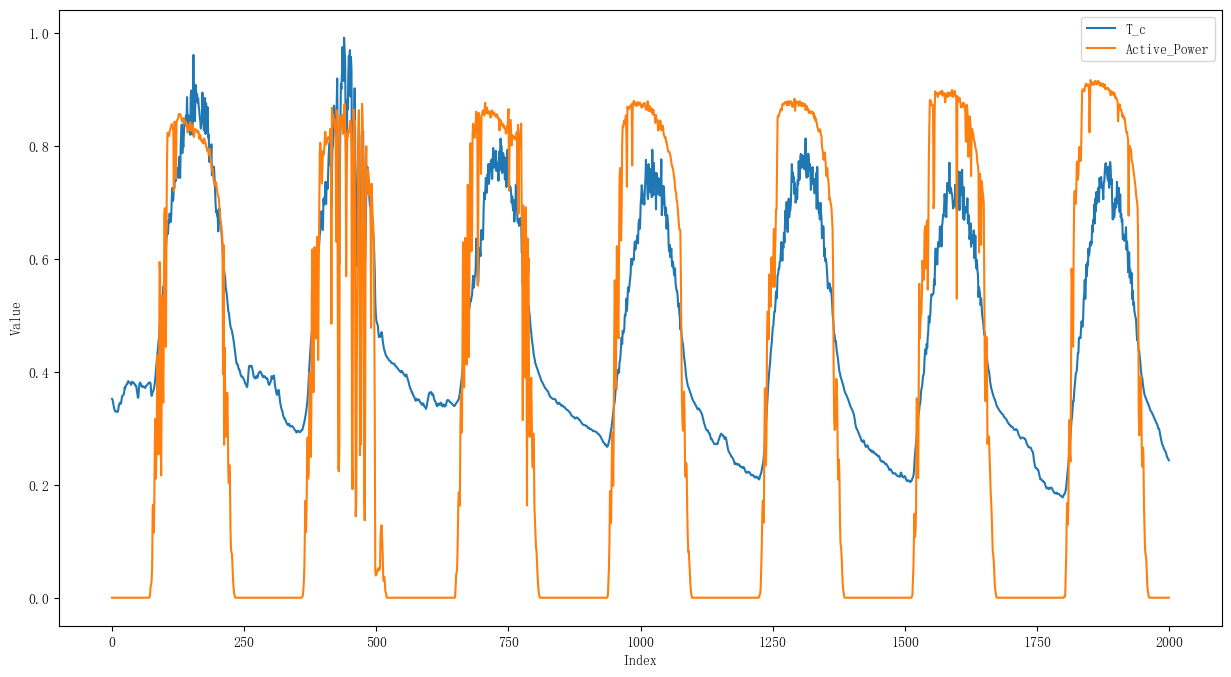

In [10]:
# 绘制出来看看曲线有没有用
plt.figure(figsize=(15, 8))
plt.plot(Data_step2['T_c'][0:2000], label='T_c')
plt.plot(Data_step2['Active_Power'][0:2000], label='Active_Power')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data_T_c = scaler.fit_transform(np.array(Data_step2['T_c']).reshape(-1,1))
data_Active_Power = scaler.fit_transform(np.array(Data_step2['Active_Power']).reshape(-1,1))
plt.figure(figsize=(15, 8))
plt.plot(data_T_c[0:2000], label='T_c')
plt.plot(data_Active_Power[0:2000], label='Active_Power')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

目前感觉趋势差不多，就是量级不同，可以看到归一化后消弱了量级的影响，现在分析一下相关性。

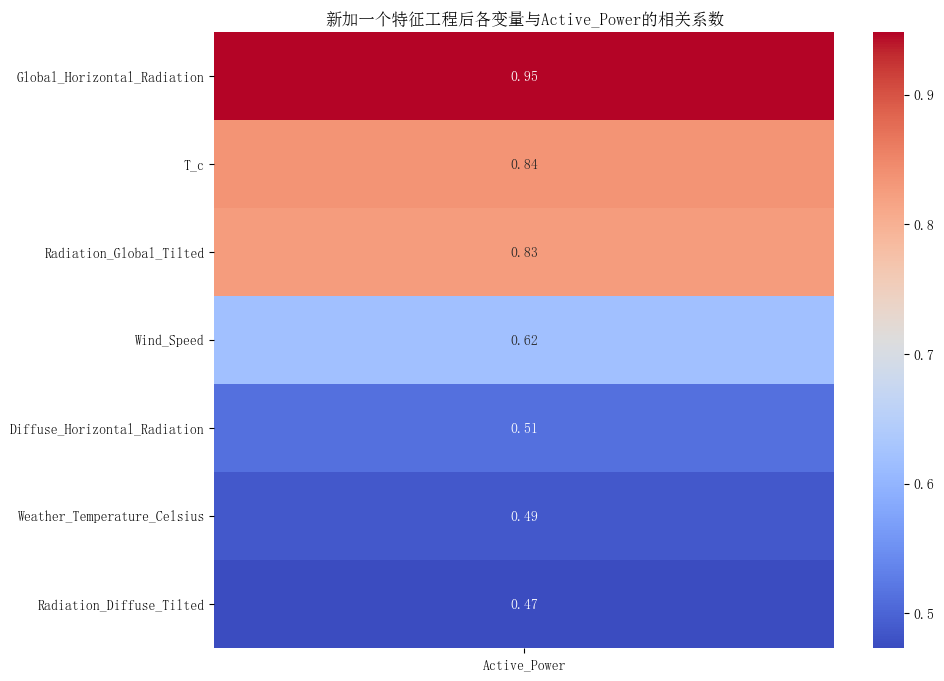

In [11]:
# 相关系数可视化
correlation_matrix = Data_step2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['Active_Power']].drop('Active_Power').sort_values(by='Active_Power', ascending=False), annot=True, cmap='coolwarm')
plt.title('新加一个特征工程后各变量与Active_Power的相关系数')
plt.show()

可以看出删掉一部分数据后相关性改变，但是T_C的效果不错，这也说明该文献的方法和一些经验系数都很适用。
其他的一些工程可以后续再加，由于Pychaem内存总不够，先保存数据。

In [12]:
Data_step2.to_csv("D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\step3_data.csv", index=False)
